In [9]:
#  Machine Learning for Stock Trading - Course by Genbox Gaming on Udemy

#Step 1: Obtaining Historical Data

# importing the packages for this task 

import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
import datetime 
from datetime import date,time

#Yahoo data 
import yfinance as yf 
from yahoofinancials import YahooFinancials 

import warnings
warnings.filterwarnings("ignore")


Price   Ticker
Close   PLTR      float64
High    PLTR      float64
Low     PLTR      float64
Open    PLTR      float64
Volume  PLTR        int64
dtype: object
MultiIndex([( 'Close', 'PLTR'),
            (  'High', 'PLTR'),
            (   'Low', 'PLTR'),
            (  'Open', 'PLTR'),
            ('Volume', 'PLTR')],
           names=['Price', 'Ticker'])


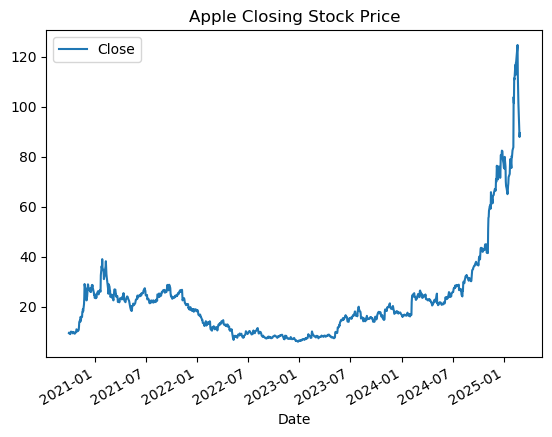

In [111]:
#Download the Historical Data. 

#Dataframe where the data is downloaded 
# We have used up to 15 years of data to avoid overfitting the model. 
df = yf.download("PLTR", 
                start= "2010-01-01",
                end = date.today(), 
                progress = False)

#Create a chart 
#Data frame contains Open, High, Low, Close, Adj Close, Volume 
#We want to plot the Close price on Y-axis and Date on X

print(df.dtypes)
print(df.columns)
df.columns = df.columns.get_level_values(0)

df.plot(y="Close", title="Apple Closing Stock Price")
plt.show()

Price           Close     RSI(2)   CCI(100)
Date                                       
2021-02-23  26.750000  30.366058  34.197328
2021-02-24  26.389999  24.755799  36.915106
2021-02-25  23.959999   7.084869  19.219162
2021-02-26  23.900000   6.843634  10.978205
2021-03-01  24.809999  54.174240  22.676982


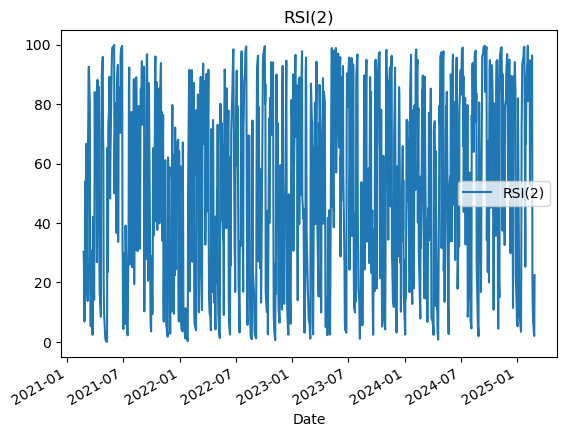

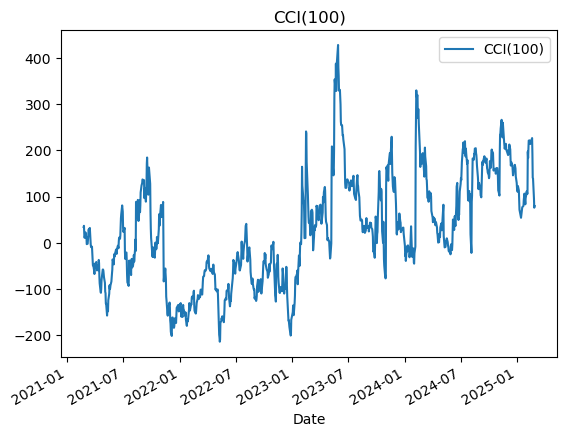

In [112]:
# Step 2: Creating Technical Analysis Indicators + Plot them

try: 
    import pandas_ta as ta #pandas technical analysis lib - lets us call any technical analysis indicator w/o needing formula 
except:
    !pip install -q pandas_ta
    import pandas_ta as ta

#creating new columns in our dataframe that are RSI indicators
#Here the 'ta' library from pandas will generate the rsi indicator for us using the closing data column from our dataframe. 

# Check if the columns are a MultiIndex
if isinstance(df.columns, pd.MultiIndex):
    # For example, take the second level as the new columns
    df.columns = df.columns.get_level_values(1)
import pandas_ta as ta  # Ensure pandas_ta is imported

# Create RSI indicator columns
df['RSI(2)'] = ta.rsi(df['Close'], length=2)
df['RSI(7)'] = ta.rsi(df['Close'], length=7)
df['RSI(14)'] = ta.rsi(df['Close'], length=14)

# Create CCI indicator columns
df['CCI(30)'] = ta.cci(close=df['Close'], length=30, high=df['High'], low=df['Low'])
df['CCI(50)'] = ta.cci(close=df['Close'], length=50, high=df['High'], low=df['Low'])
df['CCI(100)'] = ta.cci(close=df['Close'], length=100, high=df['High'], low=df['Low'])

# Optionally, ensure the RSI column is numeric
df['RSI(2)'] = pd.to_numeric(df['RSI(2)'], errors='coerce')

# Drop any rows that still have NaN values
df = df.dropna()

# Check the data
print(df[['Close', 'RSI(2)', 'CCI(100)']].head())

df.plot(y="RSI(2)", title="RSI(2)")
plt.show()

df.plot(y="CCI(100)", title="CCI(100)")
plt.show()


In [114]:
# Step 3: We now want to label the data 

# we want to buy at market open (buy the next data open)
# we want to close our trade the day after at open.

# Formula: Buy: Open(-1) - Closing: Open(-2)

# We want a buy signal if: Open(-2) > Open(-1)
# We want to sell if: Open(-2) < Open(-1)

# Our labels take a look ahead of time to determine if we have a pattern

# Creating a label in the df. using the numpy if-else statement that says: 
        # If the condition is true, it assigns “1”.
        # If the condition is false, it assigns “0”.

# np.where(condition, value_if_true, value_if_false).

# The shift command is pulling back the values in future rows into the current row that is being looked at. E.g., shift.(-n) 
# applied to row 0 of open price data will take the opening price n rows ahead (in row n) and bring it into row 0. 

# The code below is taking the values in the open column and shifting them backwards by 2 steps. It is then comparing whether this value
# greater than - given by the method .gt() - the same values shifted back 1 step. 

# If it it true, it labels it 1 and if it is false, label it 0. 

# This part of the code is forward-looking as it uses future data to assign a label to the current row.
# It is checking if the opening price two days ahead(day 2) is greater than the opening price one day ahead (day 1) and, based on that, assigns the label.

# I can do this since the data that we have is already generated, so we are able to look into the future to determine our decision today

df['Label'] = np.where(df['Open'].shift(-2).gt(df['Open'].shift(-1)), "1", "0") 
df = df.dropna()
df.head()

# essentially, when we have a "1" label in the dataframe, it signals a winning trade. 
# By forward looking at the dataset, the labels tell us whether or not this technique worked based on the open prices being > or not. 

Price,Close,High,Low,Open,Volume,RSI(2),RSI(7),RSI(14),CCI(30),CCI(50),CCI(100),Label
Date,,,,,,,,,,,,
2021-02-23,26.750000,27.459999,23.900000,25.959999,145289400,30.366058,37.018615,43.133885,-81.143436,-53.920445,34.197328,0
2021-02-24,26.389999,27.230000,25.750000,26.709999,90095700,24.755799,35.906936,42.491570,-75.118091,-46.005503,36.915106,0
2021-02-25,23.959999,26.440001,23.150000,25.820000,161776400,7.084869,29.039453,38.341229,-105.593769,-80.085604,19.219162,1
2021-02-26,23.900000,24.500000,22.700001,24.200001,119588600,6.843634,28.880339,38.241906,-115.659518,-92.460802,10.978205,0
2021-03-01,24.809999,25.900000,24.620001,25.190001,85059900,54.174240,35.166178,40.748911,-92.833136,-66.270741,22.676982,0


In [117]:
#Step 4: The next step is training our Neural Network

# We need to import Sklearn to code the model 

import sklearn 
#import each dependency 
from sklearn.neural_network import MLPClassifier #type of neural network used for classification tasks, where the model tries to predict which category or class each input belongs to.
from sklearn.neural_network import MLPRegressor # Used for regression tasks where the goal is to predict a continuous value
from sklearn.model_selection import train_test_split # split the data up so the model is trained on part of the data and then tested on the rest, checking performance on unseen data. 
from sklearn.metrics import mean_squared_error # checks the accuracy of the model 
from math import sqrt
from sklearn.metrics import r2_score

# Fitting the indicators and labelling 

# For 'x' we are selecting the input data for model by selecting the indictor columns from the df. 
# We are selecting all the columns starting from index position 6 up to the second to last one.
# These columns are the indicators in the df, that the Neural Network will use to make predictions. 

x = df[df.columns[6:-1]].values 

# Next, we need to get the label column and assign them to y. These y values are what the Neural Network has to try and predict.
# These labels are used to tell the NN whether or not the prediction was correct during the training. \

y = df['Label'].values 

#Now we split the testing and training data:

    # Reserving 30% of the data to test -> x_test and y_test
    # And 70% is to train the model -> x_train and y_train

# Doing this helps the model not overfit the data.

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3) # From sklearn.model_selection

#### Creating the Neural Network ####

# the MLPClassifer initialises the Neural Network with the following parameters:

    # hidden_layer_sizes=(8,8,8) -> Creates a NN with 3 layers, each with 8 Neurons. 
    # activation="relu" -> sets the activation function to ReLU (Rectified Linear Unit) introduces non-linearity to the model and helps it learn more complex patterns.
    # solver="adam" -> This specifies the optimization algorithm, which helps the model update its weights during training. Adam is an adaptive optimizer. 
    # max_iter= 1000 -> This sets the maximum number of iterations (epochs) to 1000. During each iteration, the NN adjusts its weights based on the training data to minimize error.

mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation="relu", solver="adam", max_iter= 1000)

# The code below trains the NN using the training data as inputs 
# The NN learns to map the input features (x_train) to the correct labels (y_train).

mlp.fit(x_train, y_train)

# The next code is used to make predictions on the training set. 
# The NN is predicting the labels for the same data it was trained on.
# Note that we still use the NN to predict the label for the training data too, as it was 
# only trained on this data to learn. 

# Now we are applying the Neural Network to the dataset: 

predict_train = mlp.predict(x_train)

# The next code is used to make predictions on the testing set. 
# The NN is predicting the labels for the new data it was not trained on.
predict_test = mlp.predict(x_test)

from sklearn.metrics import classification_report, confusion_matrix

print("Train Data Accuracy")
print(classification_report(y_train, predict_train))

print("Testing Data Accuracy")
print(classification_report(y_test, predict_test))

#classification_report: This function provides detailed performance metrics for classification:
    # Precision: How many of the predictions for a class were correct.
	# Recall: How many of the actual instances of a class were correctly identified.
	# F1-Score: The harmonic mean of precision and recall, giving you a balanced measure of the two.
	# Accuracy: The overall percentage of correct predictions.
	# confusion_matrix: This generates a matrix that shows how many true positive, true negative, false positive, and false negative predictions the model made.


# So, overall what the Neural Network that we created is trying to do:

        # classify the data into labels '1' or '0'. 
        # predict whether the Label is “1” or “0” based on the technical indicators.
        # After training on 70% of the data, it makes predictions on both the training and testing sets. 
        # The classification report then evaluates how well it performed on each set, 
        # giving us an idea of the model’s accuracy and performance on unseen data.

Train Data Accuracy
              precision    recall  f1-score   support

           0       0.56      0.64      0.60       363
           1       0.55      0.46      0.50       342

    accuracy                           0.55       705
   macro avg       0.55      0.55      0.55       705
weighted avg       0.55      0.55      0.55       705

Testing Data Accuracy
              precision    recall  f1-score   support

           0       0.50      0.64      0.56       151
           1       0.51      0.38      0.43       152

    accuracy                           0.50       303
   macro avg       0.51      0.51      0.50       303
weighted avg       0.51      0.50      0.50       303



[]

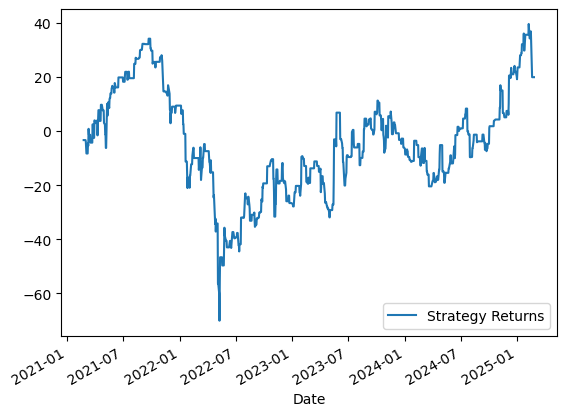

In [119]:
# Step 5: Backtesting our Model by measuring returns obtaining by trading

# This first code adds a column to the dataframe called 'Prediction' which 
# consists of the models predictions for the training set and the testing set
# This new column has the model prediction of whether the price will increase or not
# based on our strategy of buying tomorrow open and then selling the next day open

df["Prediction"] = np.append(predict_train, predict_test)

# Now we calculate the returns. 
# the np.where function is again acting like a if-else statement. 
# the condition is: 
    # the prediction = 1 i.e., the NN has assigned a label of 1 - it thinks the price will increase. 
    # If this is TRUE, the strategy assumes we buy the asset at the next day open 'df["Open"].shift(-1)'
# and then sell it the day after 'df["Open"].shift(-2)'. 
# So let's calculates the return of the Open price 2 days ahead and the Open price 1 day ahead (sell price and buy price)

# If the condition is FALSE, then the return is 0 as there is no trade made

df["Strategy Returns"] = np.where(df["Prediction"].eq("1"),((df["Open"].shift(-2)-df["Open"].shift(-1))/df["Open"].shift(-1)) *100,0)

# The strategy returns column now has the profit or loss made for each row when the Neural Network indicates a buy.

# Let's now calculate the cumulative sum of returns over time. 
# We are showing how the return over the entire period plays out 

#.cumsum() changes the strategy returns column values into the cummulative sum 
df["Strategy Returns"] = df["Strategy Returns"].cumsum()

# Plotting the cumulative return over time of the strategy based on the NN predictions.

df.plot(y = "Strategy Returns")
plt.plot()

In [121]:
# Step 5: Create a prediction for the next trading days

# The goal of this is to check if the strategy would have been profitable 

# Assigning the prediction value to 'prediction' variable.
# The -1 index refers to the last row in the DataFrame. 
# Since the DataFrame contains both historical data and predictions, 
# the last row will contain the most recent prediction from the model.

# ["Prediction"]: This extracts the value from the "Prediction" column 
# in the last row, which represents the model’s prediction for the last 
# available day of data.

prediction = df.iloc[-1]["Prediction"]

# creating an if-else statement to tell us what the model is predicting.
# It checks the value of the prediction variable made above. 
# If the prediction is "1", it assumes the model is forecastng the price to increase in the near future
# Else, it assumes a forecast of price decrease

# This only looks at the last trading day and outputs a forecast on what it could be.
 
if prediction == "1":
    print("Todays forecast is: Up")
else:
    print("Today's forecast is: Down")

Today's forecast is: Down


Training Accuracy: 55.46%
Testing Accuracy: 50.50%


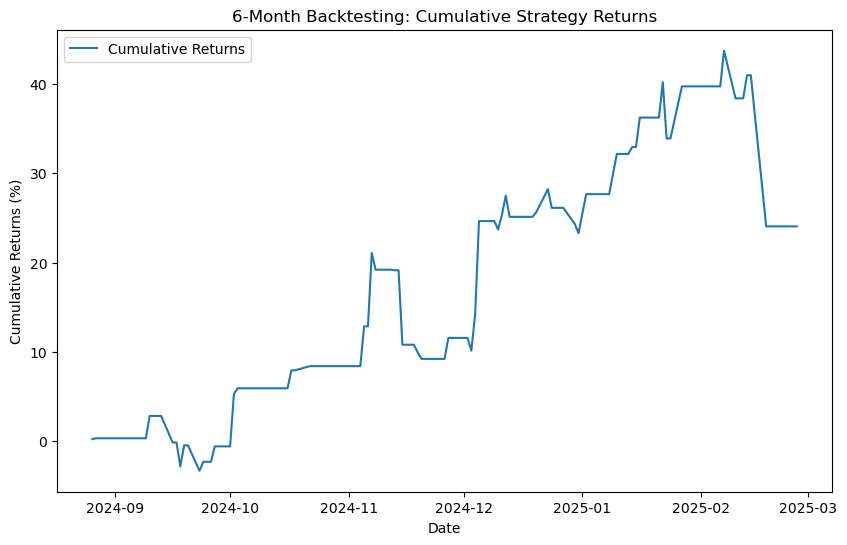

Simulated Trading Profit over 6 months: 24.05%


In [123]:
# -------------------------
# Supplemental Accuracy & Backtesting Code (scikit-learn only)
# -------------------------

from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

# Evaluate the neural network model's accuracy on training and testing sets.
train_accuracy = accuracy_score(y_train, predict_train)
test_accuracy = accuracy_score(y_test, predict_test)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")
# Ideally, test_accuracy should be around 80%

# --------------- Backtesting Over the Last 6 Months ---------------
# Ensure the DataFrame's index is in datetime format
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

# Filter the DataFrame for the last 6 months
six_months_ago = df.index.max() - pd.DateOffset(months=6)
backtest_df = df.loc[df.index >= six_months_ago].copy()

# Create the Strategy Returns column for backtesting.
# If the model predicts "1", then we assume:
#   Buy at next day's open (shift -1) and sell at the following day's open (shift -2)
backtest_df["Strategy Returns"] = np.where(
    backtest_df["Prediction"].eq("1"),
    ((backtest_df["Open"].shift(-2) - backtest_df["Open"].shift(-1)) / backtest_df["Open"].shift(-1)) * 100,
    0
)

backtest_df = backtest_df.dropna(subset=["Strategy Returns"])
backtest_df["Cumulative Strategy Returns"] = backtest_df["Strategy Returns"].cumsum()


# Calculate the cumulative returns to simulate total profit over time.
backtest_df["Cumulative Strategy Returns"] = backtest_df["Strategy Returns"].cumsum()

# Plot the cumulative strategy returns over the last 6 months.
plt.figure(figsize=(10,6))
plt.plot(backtest_df.index, backtest_df["Cumulative Strategy Returns"], label="Cumulative Returns")
plt.title("6-Month Backtesting: Cumulative Strategy Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (%)")
plt.legend()
plt.show()

final_profit = backtest_df["Cumulative Strategy Returns"].iloc[-1]
print(f"Simulated Trading Profit over 6 months: {final_profit:.2f}%")



In [135]:
########################################
# 1. Convert 'Label' to numeric integers
########################################

# Currently your labels might be "0" and "1" as strings.
# Convert them to int for TensorFlow.
df['Label'] = df['Label'].astype(int)

########################################
# 2. Define X (features) and y (labels)
########################################

# Suppose your technical indicators and other features start at column index 6
# and go until just before the 'Label' column (the last column).
# Adapt these indices to match your DataFrame structure.

print(df.columns)

X = df[['RSI(2)', 'RSI(7)', 'RSI(14)', 'CCI(30)', 'CCI(50)', 'CCI(100)']].values # Features from the 7th column up to second-to-last
y = df['Label'].values           # Numeric 0/1 labels

########################################
# 3. Split and Scale
########################################

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split into train/test (70/30 as in your original code)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

# (Optional) Scale features for smoother neural network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

########################################
# 4. Build & Train a Keras Model
########################################

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Initialize a sequential model
model = Sequential()

# Input layer size = number of features in X
input_dim = X_train_scaled.shape[1]

# Example architecture:
#  - 1st layer: 16 neurons, ReLU activation
#  - 2nd layer: 8 neurons, ReLU activation
#  - Dropout layers can help reduce overfitting
model.add(Dense(16, activation='relu', input_shape=(input_dim,)))
model.add(Dropout(0.2))  # Drop 20% of neurons randomly during training
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Single neuron for binary classification

# Compile the model
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

# Train the model
# validation_split=0.2 means 20% of the training data is used as a validation set
history = model.fit(
    X_train_scaled, 
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

########################################
# 5. Evaluate the Model
########################################

test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'RSI(2)', 'RSI(7)', 'RSI(14)',
       'CCI(30)', 'CCI(50)', 'CCI(100)', 'Label', 'Prediction',
       'Strategy Returns'],
      dtype='object', name='Price')
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4852 - loss: 0.7444 - val_accuracy: 0.4610 - val_loss: 0.7114
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5214 - loss: 0.7244 - val_accuracy: 0.4468 - val_loss: 0.7015
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5430 - loss: 0.7055 - val_accuracy: 0.4681 - val_loss: 0.6957
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5195 - loss: 0.7150 - val_accuracy: 0.4823 - val_loss: 0.6935
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5481 - loss: 0.6969 - val_accuracy: 0.5177 - val_loss: 0.6927
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5400 - loss: 0.7021 - val_accuracy: 0.5177 - val_loss: 0.6928
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━

In [137]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Predict on test set
y_pred_prob = model.predict(X_test_scaled)  # returns probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("Classification Report:\n", cr)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion Matrix:
 [[125  14]
 [143  21]]
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.90      0.61       139
           1       0.60      0.13      0.21       164

    accuracy                           0.48       303
   macro avg       0.53      0.51      0.41       303
weighted avg       0.54      0.48      0.40       303

